In [1]:
%matplotlib inline


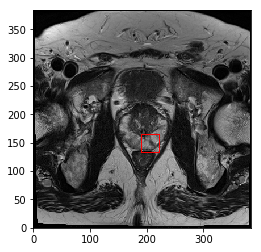

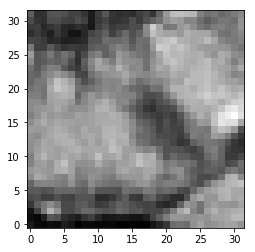

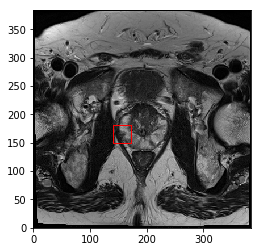

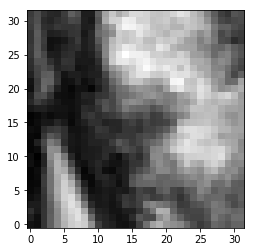

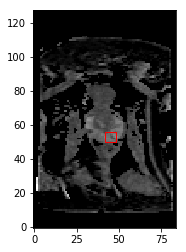

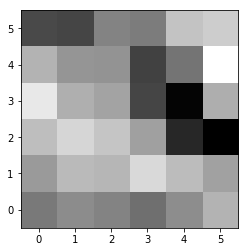

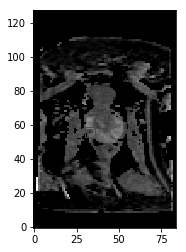

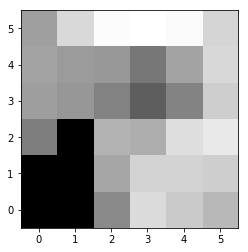

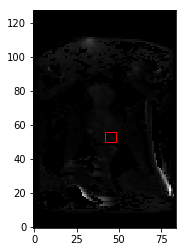

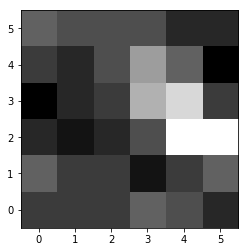

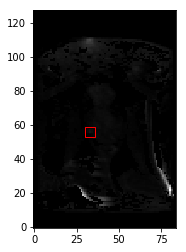

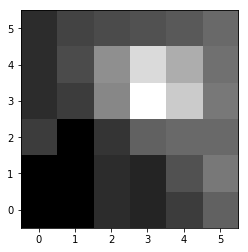

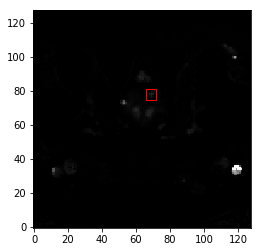

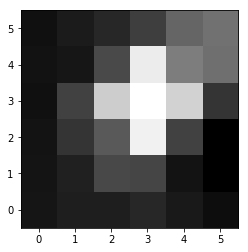

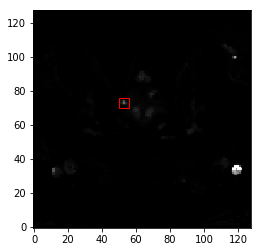

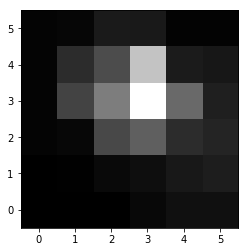

In [2]:
"""
Author: Alex Hamilton - https://github.com/alexhamiltonRN
Created: 2018-10-30 7:56 PM
Description:
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import SimpleITK as sitk
from pathlib import Path

## load training_tables
t2_train_table = pd.read_pickle('/Users/alexanders-13mbp/Documents/DataProjects/Data/MBI/ProstateX/generated/tables/t2_train.pkl')
adc_train_table = pd.read_pickle('/Users/alexanders-13mbp/Documents/DataProjects/Data/MBI/ProstateX/generated/tables/adc_train.pkl')
bval_train_table = pd.read_pickle('/Users/alexanders-13mbp/Documents/DataProjects/Data/MBI/ProstateX/generated/tables/bval_train.pkl')
ktrans_train_table = pd.read_pickle('/Users/alexanders-13mbp/Documents/DataProjects/Data/MBI/ProstateX/generated/tables/ktrans_train.pkl')

def load_image(path_to_resampled_file):
    sitk_image = sitk.ReadImage(str(path_to_resampled_file))
    image_array = sitk.GetArrayViewFromImage(sitk_image)
    return sitk_image, image_array

def calculate_location_of_finding(sitk_image, reported_position):
    location_of_finding = sitk_image.TransformPhysicalPointToIndex(reported_position)
    return location_of_finding

def calculate_origin_size_patch(location_of_finding, desired_patch_size):
    # x, y - if origin lower
    x = location_of_finding[0]
    y = location_of_finding[1]
    rect_x = x - desired_patch_size // 2 
    rect_y = y - desired_patch_size // 2
    return (rect_x, rect_y, desired_patch_size)

def extract_patch(image_array, location_of_finding, desired_patch_size):
    x = location_of_finding[0]
    y = location_of_finding[1]

    arr_x_start_index = x - (desired_patch_size // 2)
    arr_x_end_index = x + (desired_patch_size // 2)
    arr_y_start_index = y - (desired_patch_size // 2)
    arr_y_end_index = y + (desired_patch_size //2)

    extracted_patch = image_array[location_of_finding[2], arr_y_start_index:arr_y_end_index, arr_x_start_index:arr_x_end_index]

    return extracted_patch

def plot_sig_sequence_for_patient(patient_id, desired_sequence, desired_patch_size):
    significant_sequences = pd.DataFrame()
    
    if desired_sequence == 't2':
        significant_sequences = t2_train_table[(t2_train_table['ClinSig'] == True) & (t2_train_table['ProxID'] == patient_id)]
    elif desired_sequence == 'adc':
        significant_sequences = adc_train_table[(adc_train_table['ClinSig'] == True) & (adc_train_table['ProxID'] == patient_id)]
    elif desired_sequence == 'bval':
        significant_sequences = bval_train_table[(bval_train_table['ClinSig'] == True) & (bval_train_table['ProxID'] == patient_id)]
    elif desired_sequence == 'ktrans':
        significant_sequences = ktrans_train_table[(ktrans_train_table['ClinSig'] == True) & (ktrans_train_table['ProxID'] == patient_id)]

    for row in significant_sequences.itertuples():
        path_to_resampled_file = getattr(row, 'path_to_resampled_file')
        reported_position = getattr(row, 'pos')
        sitk_image, image_array = load_image(path_to_resampled_file)
        location_of_finding = calculate_location_of_finding(sitk_image, reported_position)
        origin_size_patch = calculate_origin_size_patch(location_of_finding, desired_patch_size)
        extracted_patch = extract_patch(image_array, location_of_finding, desired_patch_size)

        fig, ax = plt.subplots(1)
        ax.imshow(image_array[location_of_finding[2],:,:], cmap = 'gray', origin = 'lower')
        rect = patches.Rectangle((origin_size_patch[0], origin_size_patch[1]), desired_patch_size, desired_patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        plt.imshow(extracted_patch, cmap = 'gray', origin = 'lower')
        plt.show()

plot_sig_sequence_for_patient('ProstateX-0005', 't2', 32)
plot_sig_sequence_for_patient('ProstateX-0005', 'adc', 6)
plot_sig_sequence_for_patient('ProstateX-0005', 'bval', 6)
plot_sig_sequence_for_patient('ProstateX-0005', 'ktrans', 6)
